In [1]:
#Import libraries

import pandas as pd
import numpy as np

!pip install -q fastai==2.2.5 fastcore==1.3.19 fast-tabnet==0.2.0

from fastai.tabular.all import *
from fast_tabnet.core import *

!pip install -Uqq fastbook 
import fastbook
fastbook.setup_book()

from fastbook import *

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#set input path and download the test and training datasets

input_path = Path('/kaggle/input/tabular-playground-series-jan-2021')
train_df = pd.read_csv(input_path/'train.csv')
test_df = pd.read_csv(input_path/'test.csv')

In [3]:
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): 
    return r_mse(m.predict(xs), y)

In [4]:
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [5]:
train_df_bkp = train_df.copy(deep=False)

In [6]:
from sklearn.model_selection import train_test_split

target = train_df.pop('target')
X_train, X_test, y_train, y_test = train_test_split(train_df, target, train_size=0.80)

# Simple model #1: Decision tree with stopping criteria (max leaves = 4)

In [7]:
from sklearn.tree import DecisionTreeRegressor

#Creating a Decision tree -- with stopping criteria (max leaves = 4)

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(X_train, y_train);

In [8]:
print ("training error", m_rmse(m, X_train, y_train))
print ("test error", m_rmse(m, X_test, y_test))

training error 0.728172
test error 0.725077


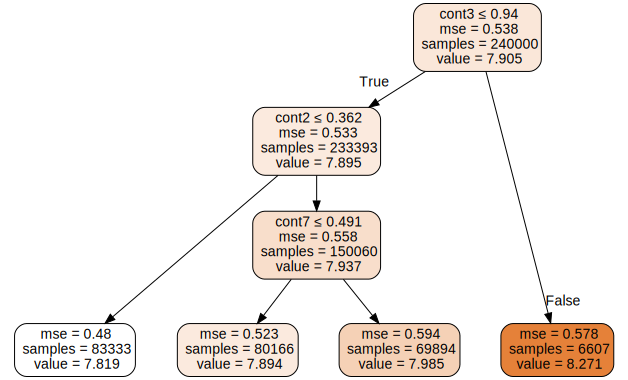

In [9]:
draw_tree(m, X_train, size=15, leaves_parallel=True, precision=3)

### with 25 max leaf nodes

In [10]:
m25 = DecisionTreeRegressor(max_leaf_nodes=25)
m25.fit(X_train, y_train);

In [11]:
print ("training error", m_rmse(m25, X_train, y_train))
print ("test error", m_rmse(m25, X_test, y_test))

training error 0.720927
test error 0.719594


# Simple model #2: Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=40, max_samples=50000,
       max_features='sqrt', min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [13]:
mrf = rf(X_train, y_train)

In [14]:
# before box cox
print ("training error", m_rmse(mrf, X_train, y_train))
print ("test error", m_rmse(mrf, X_test, y_test))

training error 0.6403
test error 0.706009


In [15]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [16]:
fi = rf_feat_importance(mrf, X_train)
fi[:14]

,cols,imp
3,cont3,0.072953
13,cont13,0.072852
2,cont2,0.071401
4,cont4,0.070929
7,cont7,0.070047
1,cont1,0.068247
10,cont10,0.067202
12,cont12,0.066116
6,cont6,0.066006
11,cont11,0.065936


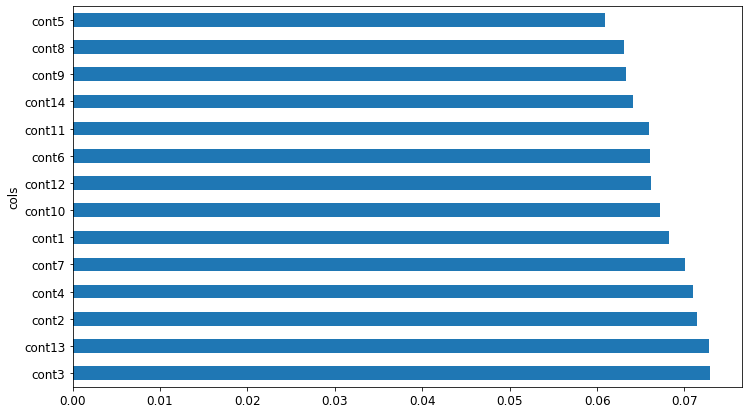

In [17]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:14]);

# Light GBM

In [18]:
#remove the id columns 

X_train.pop('id')
X_test.pop('id')

4941        8253
51775      85908
115253    191780
299321    498895
173570    289286
           ...  
75094     124796
171847    286409
138313    230266
271268    452201
72612     120590
Name: id, Length: 60000, dtype: int64

In [19]:
import lightgbm as lgb

LGB = lgb.LGBMRegressor(random_state=33, n_estimators=5000, min_data_per_group=5, boosting_type='gbdt',
 num_leaves=246, max_dept=-1, learning_rate=0.005, subsample_for_bin=200000,
 lambda_l1= 1.07e-05, lambda_l2= 2.05e-06, n_jobs=-1, cat_smooth=1.0, 
 importance_type='split', metric='rmse', min_child_samples=20, min_gain_to_split=0.0, feature_fraction=0.5, 
 bagging_freq=6, min_sum_hessian_in_leaf=0.001, min_data_in_leaf=100, bagging_fraction=0.80)

In [20]:
m_LGB = LGB.fit(X_train, y_train)

In [21]:
print ("training error", m_rmse(m_LGB, X_train, y_train))
print ("test error", m_rmse(m_LGB, X_test, y_test))

training error 0.599146
test error 0.694172


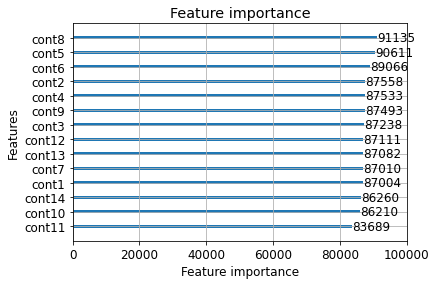

In [22]:
#view the importance of the features

lgb.plot_importance(m_LGB, ax=None, height=0.2, xlim=None, ylim=None, 
                      title='Feature importance', xlabel='Feature importance', ylabel='Features', 
                      importance_type='split', max_num_features=None, 
                      ignore_zero=True, figsize=None, dpi=None, grid=True, precision=7)

# Hypothesis: feature scaling : box-cox transformation

In [23]:

input_path = Path('/kaggle/input/tabular-playground-series-jan-2021')
train_df = pd.read_csv(input_path/'train.csv')
test_df = pd.read_csv(input_path/'test.csv')

In [24]:
from scipy.stats import boxcox

train_df['cont5'] = boxcox(train_df['cont5'], 0)

In [25]:
target = train_df.pop('target')

X_train, X_test, y_train, y_test = train_test_split(train_df, target, train_size=0.80)

In [26]:
#remove the id columns 

X_train.pop('id')
X_test.pop('id')

169670    282649
272842    454839
152973    254728
291510    485955
104974    174626
           ...  
271025    451812
112888    187858
105006    174678
71416     118570
189312    315475
Name: id, Length: 60000, dtype: int64

In [27]:
import lightgbm as lgb

LGB = lgb.LGBMRegressor(random_state=33, n_estimators=5000, min_data_per_group=5, boosting_type='gbdt',
 num_leaves=246, max_dept=-1, learning_rate=0.005, subsample_for_bin=200000,
 lambda_l1= 1.07e-05, lambda_l2= 2.05e-06, n_jobs=-1, cat_smooth=1.0, 
 importance_type='split', metric='rmse', min_child_samples=20, min_gain_to_split=0.0, feature_fraction=0.5, 
 bagging_freq=6, min_sum_hessian_in_leaf=0.001, min_data_in_leaf=100, bagging_fraction=0.80)

m_LGB_box_cox = LGB.fit(X_train, y_train)

In [28]:
print ("training error", m_rmse(m_LGB_box_cox, X_train, y_train))
print ("test error", m_rmse(m_LGB_box_cox, X_test, y_test))

training error 0.598786
test error 0.695292


# Hypothesis 2: Normalizing leads to better performance
**##### Excluded from the article**

In [29]:
SEED = 42
set_seed(SEED, reproducible=True)

y_names = ['target']
contl = list(train_df_bkp.columns.values)
contl.remove('id')
cont_names = contl

#cat_names is blank because the dataset does not contain any categorical variables

cat_names = []

procs = [FillMissing, Normalize]
#procs = [FillMissing]
splits = RandomSplitter(seed=SEED)(range_of(train_df))

In [30]:
#using tabular pandas
to = TabularPandas(
    train_df_bkp, 
    procs=procs, 
    cat_names=cat_names, 
    cont_names=cont_names, 
    y_names=y_names, 
    y_block=RegressionBlock(),
    splits=splits,
)

KeyError: 'target'

<Figure size 432x288 with 0 Axes>

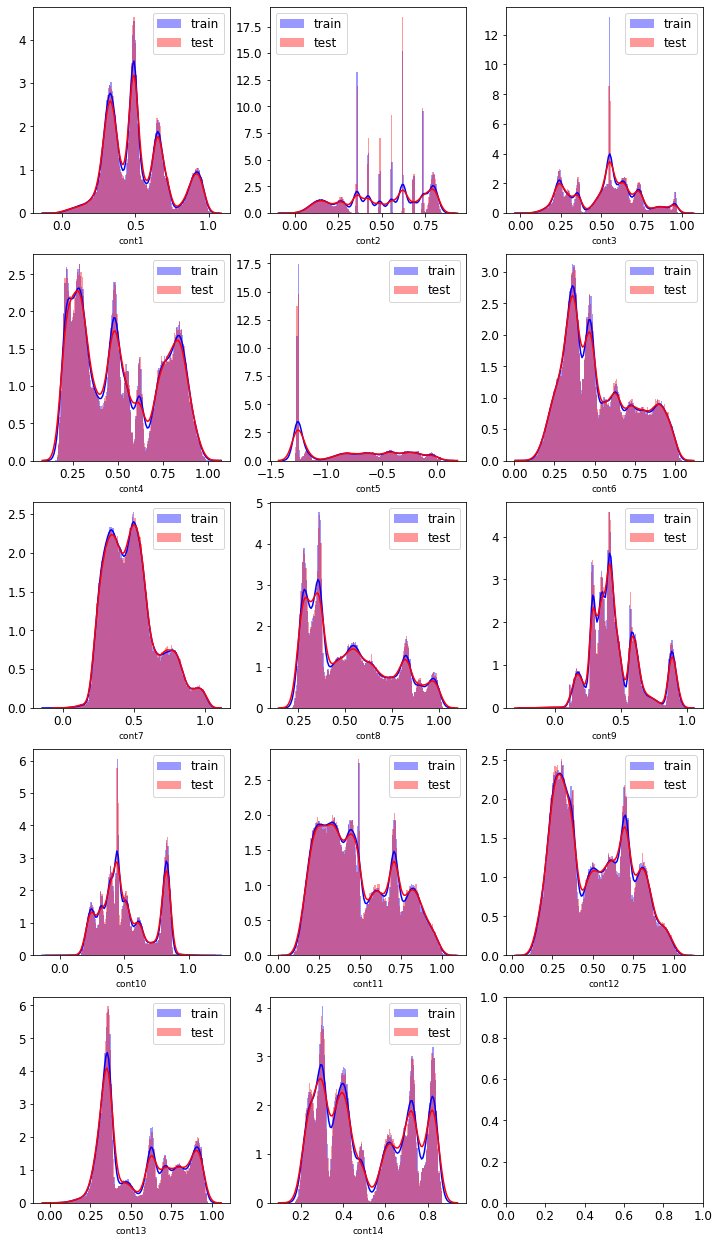

In [31]:
#visualisation before Normalisation
import seaborn as sns

j = 1
plt.figure()
fig, ax = plt.subplots(5, 3,figsize=(12, 22))
for feature in cont_names:
    plt.subplot(5, 3,j)
    sns.distplot(X_train[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(X_test[feature],color="red", kde=True,bins=120, label='test')
    plt.xlabel(feature, fontsize=9); plt.legend()
    j += 1
plt.show()

In [32]:
# before Normalisation
X_train.describe()

,cont1,cont2,cont3,cont4,...,cont11,cont12,cont13,cont14
count,240000.000000,240000.000000,240000.000000,240000.000000,...,240000.000000,240000.000000,240000.000000,240000.000000
mean,0.506662,0.497854,0.521319,0.515987,...,0.483643,0.506619,0.553135,0.503460
std,0.204081,0.228345,0.200799,0.233140,...,0.219939,0.218766,0.229662,0.208165
min,-0.082263,-0.031397,0.020967,0.152761,...,0.084331,0.088635,0.029950,0.169977
25%,0.342809,0.317402,0.343826,0.295004,...,0.300329,0.310310,0.350359,0.308597
50%,0.483765,0.553209,0.551426,0.483052,...,0.441506,0.486309,0.487571,0.431360
75%,0.643648,0.731405,0.647977,0.749078,...,0.678434,0.694220,0.767863,0.712498
max,1.016227,0.859697,1.006955,1.010402,...,1.022620,1.049025,0.977101,0.868506


<Figure size 432x288 with 0 Axes>

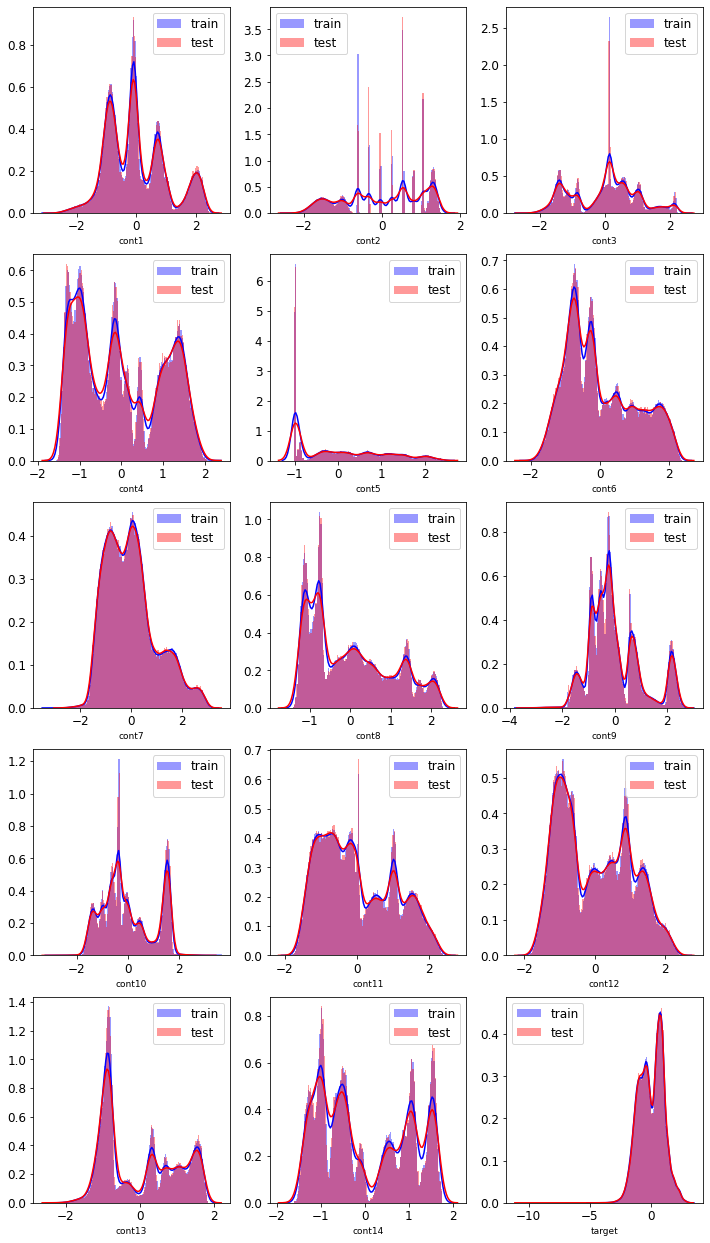

In [33]:
#visualisation after Normalisation

j = 1
plt.figure()
fig, ax = plt.subplots(5, 3,figsize=(12, 22))
for feature in cont_names:
    plt.subplot(5, 3,j)
    sns.distplot(to.train.xs[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(to.valid.xs[feature],color="red", kde=True,bins=120, label='test')
    plt.xlabel(feature, fontsize=9); plt.legend()
    j += 1
plt.show()

In [34]:
# after Normalisation
to.train.xs.describe()

,cont1,cont2,cont3,cont4,...,cont12,cont13,cont14,target
count,240000.000000,240000.000000,240000.000000,240000.000000,...,240000.000000,240000.000000,240000.000000,240000.000000
mean,0.000005,0.000091,-0.000154,-0.000013,...,0.000012,0.000014,0.000004,-0.000007
std,1.000053,1.000070,1.000000,1.000024,...,1.000026,1.000003,1.000012,1.000014
min,-2.891643,-2.321705,-2.494278,-1.556643,...,-1.899070,-2.254995,-1.620997,-4.978210
25%,-0.802807,-0.760228,-0.883457,-0.947448,...,-0.898715,-0.883058,-0.936582,-0.786370
50%,-0.111282,0.241577,0.148020,-0.140653,...,-0.090910,-0.288057,-0.344770,0.046144
75%,0.671923,1.022301,0.630515,1.001037,...,0.855729,0.935073,1.002872,0.769681
max,2.501377,1.585022,2.416517,2.123699,...,2.477030,1.848798,1.753075,3.223571


In [35]:
import lightgbm as lgb

LGB = lgb.LGBMRegressor(random_state=33, n_estimators=5000, min_data_per_group=5, boosting_type='gbdt',
 num_leaves=246, max_dept=-1, learning_rate=0.005, subsample_for_bin=200000,
 lambda_l1= 1.07e-05, lambda_l2= 2.05e-06, n_jobs=-1, cat_smooth=1.0, 
 importance_type='split', metric='rmse', min_child_samples=20, min_gain_to_split=0.0, feature_fraction=0.5, 
 bagging_freq=6, min_sum_hessian_in_leaf=0.001, min_data_in_leaf=100, bagging_fraction=0.80)

In [36]:
m_LGB_norm = LGB.fit(to.train.xs, to.train.y)

In [37]:
print ("training error", m_rmse(m_LGB_norm, to.train.xs, to.train.y))
print ("test error", m_rmse(m_LGB_norm, to.valid.xs, to.valid.y))

training error 0.020895
test error 0.046883


In [38]:
to.train.y.describe()

count    240000.000000
mean         -0.000007
std           1.000014
min          -4.978210
25%          -0.786370
50%           0.046144
75%           0.769681
max           3.223571
Name: target, dtype: float64

In [39]:
to.valid.y.describe()

count    60000.000000
mean         0.005188
std          1.000875
min        -10.785294
25%         -0.781652
50%          0.059736
75%          0.776615
max          3.094173
Name: target, dtype: float64

In [40]:
from sklearn.tree import DecisionTreeRegressor

#Creating a Decision tree -- with stopping criteria (max leaves = 4)

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(to.train.xs, to.train.y);

In [41]:
print ("training error", m_rmse(m, to.train.xs, to.train.y))
print ("test error", m_rmse(m, to.valid.xs, to.valid.y))

training error 0.317999
test error 0.322036


In [42]:
from sklearn.tree import DecisionTreeRegressor

#Creating a Decision tree -- with stopping criteria (max leaves = 4)

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(X_train, y_train);

In [43]:
print ("training error", m_rmse(m, X_train, y_train))
print ("test error", m_rmse(m, X_test, y_test))

training error 0.728179
test error 0.725039
